In [1]:
import os
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing

In [2]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [3]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())

In [4]:
# asteroids_X = asteroids_X - np.min(asteroids_X, axis=1).reshape(-1, 1)
# asteroids_X /= np.max(asteroids_X, axis=1).reshape(-1, 1)

In [4]:
asteroids_X = np.expand_dims(asteroids_X, axis=2)

In [5]:
asteroids_X.shape

(1339, 49, 1)

In [6]:
label_encoder = preprocessing.OneHotEncoder(sparse_output=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

In [7]:
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

In [9]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [10]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

def create_model():

    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)
    
    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs, 1))

    norm_layer = normalizer(input_layer)
    
    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3)(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)
    
    hidden_layer = keras.layers.Conv1D(filters=64,
                                       activation="relu",
                                       kernel_size=3)(hidden_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)
    
    hidden_layer = keras.layers.Flatten()(hidden_layer)

    hidden_layer = keras.layers.Dense(16, activation="relu")(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 49, 1)          │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 47, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        10,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,759 (65.47 KB)

 Trainable params: 16,660 (65.08 KB)

 Non-trainable params: 99 (400.00 B)

In [13]:
end_epoch = 400
batch_size = 64

# And train! With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_split=0.25,
                    sample_weight=sample_weight)

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.7650 - val_loss: 0.6198
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5515 - val_loss: 0.4829
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4486 - val_loss: 0.4239
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3926 - val_loss: 0.3976
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3487 - val_loss: 0.3562
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3139 - val_loss: 0.3203
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3075 - val_loss: 0.3264
Epoch 8/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2824 - val_loss: 0.2740
Epoch 9/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2525 - val_loss: 0.2646
Epoch 10/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2402 - val_loss: 0.2421
Epoch 11/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2264 - val_loss: 0.2462
Epoch 12/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Text(0, 0.5, 'Loss')

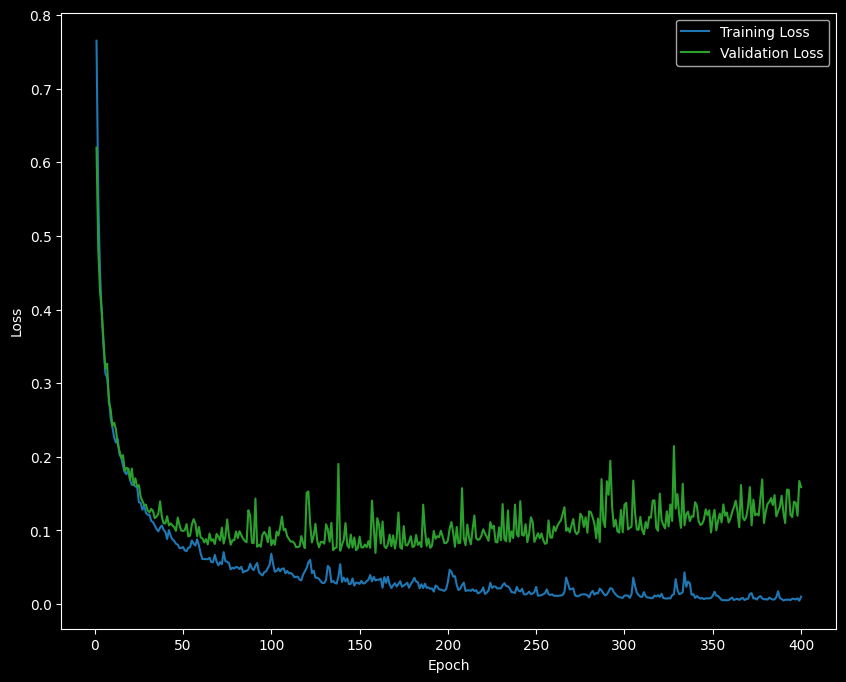

In [14]:
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [15]:
# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# Let's train
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 49, 1)          │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 47, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 21, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        10,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,759 (65.47 KB)

 Trainable params: 16,660 (65.08 KB)

 Non-trainable params: 99 (400.00 B)

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.7834 - val_loss: 0.7076
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6367 - val_loss: 0.5857
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5182 - val_loss: 0.4785
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4136 - val_loss: 0.4004
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3370 - val_loss: 0.3384
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2771 - val_loss: 0.2892
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2557 - val_loss: 0.2655
Epoch 8/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2349 - val_loss: 0.2377
Epoch 9/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2260 - val_loss: 0.2115
Epoch 10/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2038 - val_loss: 0.2008
Epoch 11/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1912 - val_loss: 0.1907
Epoch 12/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

In [16]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)

# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1

# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


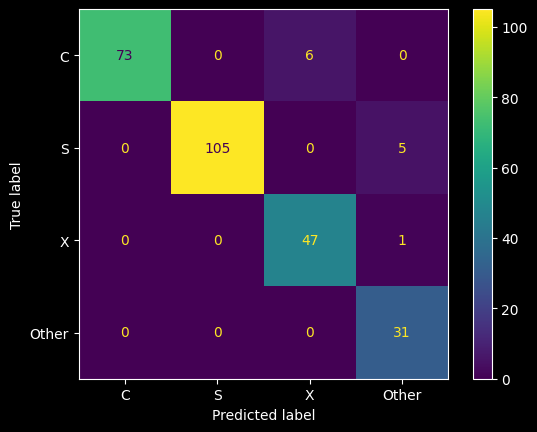

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [18]:
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test,
                                          asteroid_classes_test_pred,
                                          average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.956
